# An Asset Pricing Problem

## Overview

In this lecture we consider a some asset pricing problems and use them to
illustrate some foundations of JAX programming.

Most of the heavy lifting will be done through routines from linear algebra.

Along the way, we will show how to solve some memory-intensive problems with large state spaces.

We do this using elegant techniques made available by JAX, involving the use of linear operators to avoid instantiating large matrices.

If you wish to skip all motivation and move straight to the first equation we plan to
solve, you can jump to [](eq:ntecx2).

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

Below we use the following imports

In [2]:
import scipy
import quantecon as qe
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from collections import namedtuple

We will use 64 bit floats with JAX in order to increase precision.

In [3]:
jax.config.update("jax_enable_x64", True)

## Pricing a single payoff

Suppose, at time $t$, we have an asset that pays a random amount $D_{t+1}$ at
time $t+1$ and nothing after that.

The simplest way to price this asset is to use "risk-neutral" asset pricing, which
asserts that the price of the asset at time $t$ should be

$$
    P_t = \beta \, \mathbb E_t D_{t+1}
$$ (eq:rnp)

Here $\beta$ is a constant discount factor and $\mathbb E_t D_{t+1}$ is the expectation
of $D_{t+1}$ at time $t$.

Roughly speaking, [](eq:rnp) says that the cost (i.e., price) equals expected benefit.

The discount factor is introduced because most people prefer payments now to
payments in the future.

One problem with this very simple model is that it does not take into account
attitudes to risk.

For example, investors often demand higher rates of return for holding risky
assets.

This feature of asset prices cannot be captured by risk neutral pricing.

Hence we modify [](eq:rnp) to

$$
    P_t = \mathbb E_t M_{t+1} D_{t+1}
$$ (eq:nrnp)

In this expression, $M_{t+1}$ replaces $\beta$ and is called the **stochastic discount factor**.

In essence, allowing discounting to become a random variable gives us the
flexibility to combine temporal discounting and attitudes to risk.

We leave further discussion to [other lectures](https://python.quantecon.org/markov_asset.html)
because our aim is to move to the computational problem.



## Pricing a cash flow

Now let's try to price an asset like a share, which delivers a cash flow $D_t,
D_{t+1}, \ldots$.

We will call these payoffs "dividends".

If we buy the share, hold it for one period and sell it again, we receive one
dividend and our payoff is $D_{t+1} + P_{t+1}$.

Therefore, by [](eq:nrnp), the price should be

$$
    P_t = \mathbb E_t M_{t+1} [ D_{t+1} + P_{t+1} ]
$$ (lteeqs0)

Because prices generally grow over time, which complicates analysis, it will be
easier for us to solve for the **price-dividend ratio** $V_t := P_t / D_t$.

Let's write down an expression that this ratio should satisfy.

We can divide both sides of {eq}`lteeqs0` by $D_t$ to get

```{math}
:label: pdex

V_t = {\mathbb E}_t \left[ M_{t+1} \frac{D_{t+1}}{D_t} (1 + V_{t+1}) \right]
```

We can also write this as

```{math}
:label: pdex2

V_t = {\mathbb E}_t \left[ M_{t+1} \exp(G^d_{t+1}) (1 + V_{t+1}) \right]
```

$$
    G^d_{t+1} = \ln \frac{D_{t+1}}{D_t}
$$

is the growth rate of dividends.

Our aim is to solve [](pdex2) but before that we need to specify

1. the stochastic discount factor $M_{t+1}$ and
1. the growth rate of dividends $G^d_{t+1}$



## Choosing the stochastic discount factor

We will adopt the stochastic discount factor described in {cite}`Lucas1978`, which has the form

```{math}
:label: lucsdf
    M_{t+1} = \beta \frac{u'(C_{t+1})}{u'(C_t)}
```

where $u$ is a utility function and $C_t$ is time $t$ consumption of a representative consumer.

(An explanation of the ideas behind this expression is given in [a later lecture](https://python-advanced.quantecon.org/lucas_model.html) and we omit further details and motivation.)

For utility, we'll assume the **constant relative risk aversion** (CRRA) specification

```{math}
:label: eqCRRA
    u(c) = \frac{c^{1-\gamma}}{1 - \gamma}
```

Inserting the CRRA specification into {eq}`lucsdf` and letting

$$
    G^c_{t+1} = \ln \left( \frac{C_{t+1}}{C_t} \right)
$$

the growth rate rate of consumption, we obtain

```{math}
:label: lucsdf2
    M_{t+1}
    = \beta \left(\frac{C_{t+1}}{C_t}\right)^{-\gamma}
    = \beta \exp( G^c_{t+1} )^{-\gamma}
    = \beta \exp(-\gamma G^c_{t+1})
```



## Solving for the price-dividend ratio

Substituting [](lucsdf2) into {eq}`pdex2` gives the price-dividend ratio
formula

$$
    V_t = \beta {\mathbb E}_t
    \left[ \exp(G^d_{t+1} - \gamma G^c_{t+1}) (1 + V_{t+1}) \right]
$$ (pdex3)

We assume there is a Markov chain $\{X_t\}$, which we call
the **state process**,  such that

$$
\begin{aligned}
    & G^c_{t+1} = \mu_c + X_t + \sigma_c \epsilon_{c, t+1} \\
    & G^d_{t+1} = \mu_d + X_t + \sigma_d \epsilon_{d, t+1}
\end{aligned}
$$

Here $\{\epsilon_{c, t}\}$ and $\{\epsilon_{d, t}\}$ are IID and standard
normal, and independent of eachother.

We can think of $\{X_t\}$ as an aggregate shock that affects both consumption
growth and firm profits (and hence dividends).

We let $P$ be the [stochastic matrix that governs $\{X_t\}$](https://python.quantecon.org/finite_markov.html) and assume $\{X_t\}$ takes values in some finite set $S$.

We guess that $V_t$ is a fixed function of this state process (and this guess turns
out to be correct).

This means that $V_t = v(X_t)$ for some unknown function $v$.

By [](pdex3), the unknown function $v$ satisfies the equation

$$
    v(X_t) = \beta {\mathbb E}_t
    \left\{
        \exp[
            a + (1-\gamma) X_t +
                \sigma_d \epsilon_{d, t+1} -
                \gamma  \sigma_c \epsilon_{c, t+1}
            ]
        (1 + v(X_{t+1}))
    \right\}
$$ (eq:neweqn101)

where $a := \mu_d - \gamma \mu_c$

Since the shocks $\epsilon_{c, t+1}$ and $\epsilon_{d, t+1}$ are independent of
$\{X_t\}$, we can integrate them out.

We use the following property of lognormal distributions: if $Y = \exp(c
\epsilon)$ for constant $c$ and $\epsilon \sim N(0,1)$, then $\mathbb E Y =
\exp(c^2/2)$.

This yields

$$
    v(X_t) = \beta {\mathbb E}_t
    \left\{
        \exp \left[
            a + (1-\gamma) X_t +
                \frac{\sigma_d^2 + \gamma^2  \sigma_c^2}{2}
            \right]
        (1 + v(X_{t+1}))
    \right\}
$$ (eq:ntev)

Conditioning on $X_t = x$, we can write this as

$$
    v(x) = \beta \sum_{y \in S}
    \left\{
        \exp \left[
            a + (1-\gamma) x +
                \frac{\sigma_d^2 + \gamma^2  \sigma_c^2}{2}
            \right]
        (1 + v(y))
    \right\}
    P(x, y)
$$ (eq:ntecx)

for all $x \in S$.



Suppose $S = \{x_1, \ldots, x_N\}$.

Then we can think of $v$ as an $N$-vector and, using square brackets for indices on arrays, write

$$
    v[i] = \beta \sum_{j=1}^N
    \left\{
        \exp \left[
            a + (1-\gamma) x[i] +
                \frac{\sigma_d^2 + \gamma^2  \sigma_c^2}{2}
            \right]
        (1 + v[j])
    \right\}
    P[i, j]
$$ (eq:ntecx2)

for $i = 1, \ldots, N$.

We can write [](eq:ntecx2) in vector form as

$$
    v = K (\mathbb 1 + v)
$$ (eq:ntecxv)

where $K$ is the matrix defined by

$$
    K[i, j]
    = \beta \left\{
        \exp \left[
            a + (1-\gamma) x[i] +
                \frac{\sigma_d^2 + \gamma^2  \sigma_c^2}{2}
            \right]
    \right\} P[i,j]
$$


Notice that [](eq:ntecxv) can be written as $(I - K)v = K \mathbb 1$.

The Neumann series lemma tells us that $(I - K)$ is invertible and the solution
is

$$
    v = (I - K)^{-1} K \mathbb 1
$$ (eq:ntecxvv)

whenever $r(K)$, the spectral radius of $K$, is strictly less than one.

Once we specify $P$ and all the parameters, we can obtain $K$ and
then compute the solution [](eq:ntecxvv).


## Code


We will use the [power iteration algorithm](https://en.wikipedia.org/wiki/Power_iteration) to check the spectral radius condition.

In [4]:
def power_iteration_sr(A, num_iterations=15, seed=1234):
    """
    Power iteration method to find the spectral radius
    """
    key = jax.random.PRNGKey(seed)
    b_k = jax.random.normal(key, (A.shape[1],))
    sr = 0
    for _ in range(num_iterations):
        # calculate the matrix-by-vector product Ab
        b_k1 = jnp.dot(A, b_k)

        # calculate the norm
        b_k1_norm = jnp.linalg.norm(b_k1)

        sr = jnp.sum(b_k1*b_k)/jnp.sum(b_k*b_k)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return sr

power_iteration_sr = jax.jit(power_iteration_sr, static_argnums=(1,2))

In [5]:
def test_stability(Q):
    """
    Assert that the spectral radius of matrix Q is < 1.
    """
    sr = power_iteration_sr(Q)
    assert sr < 1, f"Spectral radius condition failed with radius = {sr}"

In what follows we assume that $\{X_t\}$, the state process, is a discretization of the AR(1) process

$$
    X_{t+1} = \rho X_t + \sigma \eta_{t+1}
$$

where $\rho, \sigma$ are parameters and $\{\eta_t\}$ is IID and standard normal.

To discretize this process we use QuantEcon.py's `tauchen` function.

Below we write a function called `create_model()` that returns a namedtuple storing the relevant parameters and arrays.

In [6]:
Model = namedtuple('Model',
                   ('P', 'S', 'β', 'γ', 'μ_c', 'μ_d', 'σ_c', 'σ_d'))

def create_model(N=100,         # size of state space for Markov chain
                 ρ=0.9,         # persistence parameter for Markov chain
                 σ=0.01,        # persistence parameter for Markov chain
                 β=0.98,        # discount factor
                 γ=2.5,         # coefficient of risk aversion
                 μ_c=0.01,      # mean growth of consumtion
                 μ_d=0.01,      # mean growth of dividends
                 σ_c=0.02,      # consumption volatility
                 σ_d=0.04):     # dividend volatility
    # Create the state process
    mc = qe.tauchen(N, ρ, σ)
    S = mc.state_values
    P = mc.P
    # Shift arrays to the device
    S, P = map(jax.device_put, (S, P))
    # Return the namedtuple
    return Model(P=P, S=S, β=β, γ=γ, μ_c=μ_c, μ_d=μ_d, σ_c=σ_c, σ_d=σ_d)

Our first step is to construct the matrix $K$.

To exploit the parallelization capabilities of JAX, we use a vectorized (i.e., loop-free) implementation.

In [7]:
def compute_K(model):
    # Setp up
    P, S, β, γ, μ_c, μ_d, σ_c, σ_d = model
    N = len(S)
    # Reshape and multiply pointwise using broadcasting
    x = jnp.reshape(S, (N, 1))
    a = μ_d - γ * μ_c
    e = jnp.exp(a + (1 - γ) * x + (σ_d**2 + γ**2 * σ_c**2) / 2)
    K = β * e * P
    return K

Just to double check, let's write a loop version and check we get the same matrix.

In [8]:
def compute_K_loop(model):
    # Setp up
    P, S, β, γ, μ_c, μ_d, σ_c, σ_d = model
    N = len(S)
    K = np.empty((N, N))
    a = μ_d - γ * μ_c
    for i, x in enumerate(S):
        for j, y in enumerate(S):
            e = jnp.exp(a + (1 - γ) * x + (σ_d**2 + γ**2 * σ_c**2) / 2)
            K[i, j] = β * e * P[i, j]
    return K

In [9]:
model = create_model(N=10)
K1 = compute_K(model)
K2 = compute_K_loop(model)
jnp.allclose(K1, K2)

Array(True, dtype=bool)

Now we can compute the price-dividend ratio:

In [10]:
def price_dividend_ratio(model, test_stable=True):
    """
    Computes the price-dividend ratio of the asset.

    Parameters
    ----------
    model: an instance of Model
        contains primitives

    Returns
    -------
    v : array_like
        price-dividend ratio

    """
    K = compute_K(model)
    N = len(model.S)

    if test_stable:
        test_stability(K)

    # Compute v
    I = jnp.identity(N)
    ones_vec = np.ones(N)
    v = jnp.linalg.solve(I - K, K @ ones_vec)

    return v

Here's a plot of $v$ as a function of the state for several values of $\gamma$.

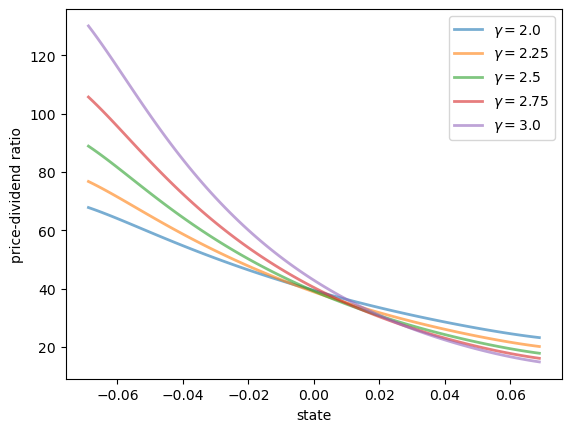

In [11]:
model = create_model()
S = model.S
γs = jnp.linspace(2.0, 3.0, 5)

fig, ax = plt.subplots()

for γ in γs:
    model = create_model(γ=γ)
    v = price_dividend_ratio(model)
    ax.plot(S, v, lw=2, alpha=0.6, label=rf"$\gamma = {γ}$")

ax.set_ylabel("price-dividend ratio")
ax.set_xlabel("state")
ax.legend(loc='upper right')
plt.show()

Notice that $v$ is decreasing in each case.

This is because, with a positively correlated state process, higher states indicate higher future consumption growth.

With the stochastic discount factor {eq}`lucsdf2`, higher growth decreases the
discount factor, lowering the weight placed on future dividends.



## An Extended Example

One problem with the last set is that volatility is constant through time (i.e.,
$\sigma_c$ and $\sigma_d$ are constants).

In reality, financial markets and growth rates of macroeconomic variables
exhibit bursts of volatility.

To accommodate this, we now develop a *stochastic volatility* model.

To begin, suppose that

$$
\begin{aligned}
    & G^c_{t+1} = \mu_c + Z_t + \bar \sigma \exp(H^c_t) \epsilon_{c, t+1} \\
    & G^d_{t+1} = \mu_d + Z_t + \bar \sigma \exp(H^d_t) \epsilon_{d, t+1}
\end{aligned}
$$

where $\{Z_t\}$ is a finite Markov chain and $\{H^c_t\}$ and $\{H^d_t\}$ are AR(1) processes of the form

$$
\begin{aligned}
    H^c_{t+1} & = \rho_c H^c_t + \sigma_c \eta_{c, t+1}  \\
    H^d_{t+1} & = \rho_d H^d_t + \sigma_d \eta_{d, t+1}
\end{aligned}
$$

Here $\{\eta^c_t\}$ and $\{\eta^d_t\}$ are IID and standard normal.

Let $X_t = (H^c_t, H^d_t, Z_t)$.

We call $\{X_t\}$ the state process and guess that $V_t$ is a function of
this state process, so that $V_t = v(X_t)$ for some unknown function $v$.

Modifying [](eq:neweqn101) to accommodate the new growth specifications,
we find that $v$ satisfies

$$
    v(X_t) = \beta {\mathbb E}_t
    \left\{
        \exp[
            a + (1-\gamma) Z_t +
                \bar \sigma \exp(H^d_t) \epsilon_{d, t+1} -
                \gamma \bar \sigma \exp(H^c_t) \epsilon_{c, t+1}
            ]
        (1 + v(X_{t+1}))
    \right\}
$$ (eq:neweqn102)

where, as before, $a := \mu_d - \gamma \mu_c$



Conditioning on state $x = (h_c, h_d, z)$, this becomes

```{math}
:label: neweqn103_old
    v(x) = \beta  {\mathbb E}_t
        \exp[
            a + (1-\gamma) z +
                \bar \sigma \exp(h_d) \epsilon_{d, t+1} -
                \gamma \bar \sigma \exp(h_c) \epsilon_{c, t+1}
            ]
        (1 + v(X_{t+1}))
```

As before, we integrate out the independent shocks and use the rules for
expectations of lognormals to obtain

```{math}
:label: neweqn103_new
    v(x) = \beta  {\mathbb E}_t
        \exp \left[
            a + (1-\gamma) z +
                \bar \sigma^2 \frac{\exp(2 h_d) + \gamma^2 \exp(2 h_c)}{2}
            \right]
        (1 + v(X_{t+1}))
```

Using the definition of the state and setting

$$
    \kappa(h_c, h_z, z) :=
        \exp \left[
            a + (1-\gamma) z +
                \bar \sigma^2 \frac{\exp(2 h_d) + \gamma^2 \exp(2 h_c)}{2}
            \right]
$$

we can write this more explicitly

```{math}
:label: neweqn104_old
    v(h_c, h_d, z) =
    \beta \sum_{h_c', h_d', z'}
        \kappa(h_c, h_z, z)
        (1 + v(h_c', h_d', z')) P(h_c, h_c')Q(h_d, h_d')R(z, z')
```

Here $P, Q, R$ are the stochastic matrices for, respectively, discretized
$\{H^c_t\}$, discretized $\{H^d_t\}$ and $\{Z_t\}$.

Let's now write the state using indices, with $(i, j, k)$ being the
indices for $(h_c, h_z, z)$.

The last expression becomes

```{math}
:label: neweqn104_new

    v[i, j, k] =
    \beta \sum_{i', j', k'}
        \kappa[i, j, k]
        (1 + v[i', j', k']) P[i, i']Q[j, j']R[k, k']
```

We define the multi-index array $H$ by

$$
    H[i, j, k, i', j', k']
    =
    \beta \sum_{i', j', k'}
        \kappa[i, j, k] P[i, i']Q[j, j']R[k, k']
$$

then {eq}`neweqn104_new` becomes

$$
    v[i, j, k] =
    \beta \sum_{i', j', k'}
        H[i, j, k, i', j', k'] (1 + v[i', j', k'])
$$ (eq:neweqn105)

One way to understand this is to reshape $v$ into an $N$-vector, where $N = I \times J \times K$,
and $H$ into an $N \times N$ matrix.

Then we can write [](eq:neweqn105) as

$$
    v = H(\mathbb 1 + v)
$$

Provided that $H$ is invertible, the solution is given by

$$
    v = (I - H)^{-1} H \mathbb 1
$$



## Numpy Version


Our first implementation will be in NumPy.

Once we have a NumPy version working, we will convert it to JAX and check the difference in the run times.

The code block below provides a function called `create_sv_model()` that returns a namedtuple containing arrays and other data that form the primitives of the problem.

It assumes that $\{Z_t\}$ is a discretization of

$$
    Z_{t+1} = \rho_z Z_t + \sigma_z \xi_{t+1}
$$

In [12]:
SVModel = namedtuple('SVModel',
                        ('P', 'hc_grid',
                         'Q', 'hd_grid',
                         'R', 'z_grid',
                         'β', 'γ', 'bar_σ', 'μ_c', 'μ_d'))

def create_sv_model(β=0.98,        # discount factor
                    γ=2.5,         # coefficient of risk aversion
                    I=14,          # size of state space for h_c
                    ρ_c=0.9,       # persistence parameter for h_c
                    σ_c=0.01,      # volatility parameter for h_c
                    J=14,          # size of state space for h_d
                    ρ_d=0.9,       # persistence parameter for h_d
                    σ_d=0.01,      # volatility parameter for h_d
                    K=14,          # size of state space for z
                    bar_σ=0.01,    # volatility scaling parameter
                    ρ_z=0.9,       # persistence parameter for z
                    σ_z=0.01,      # persistence parameter for z
                    μ_c=0.001,     # mean growth of consumtion
                    μ_d=0.005):    # mean growth of dividends

    mc = qe.tauchen(I, ρ_c, σ_c)
    hc_grid = mc.state_values
    P = mc.P
    mc = qe.tauchen(J, ρ_d, σ_d)
    hd_grid = mc.state_values
    Q = mc.P
    mc = qe.tauchen(K, ρ_z, σ_z)
    z_grid = mc.state_values
    R = mc.P

    return SVModel(P=P, hc_grid=hc_grid,
                   Q=Q, hd_grid=hd_grid,
                   R=R, z_grid=z_grid,
                   β=β, γ=γ, bar_σ=bar_σ, μ_c=μ_c, μ_d=μ_d)

Now we provide a function to compute the matrix $H$.

In [13]:
def compute_H(sv_model):
    # Set up
    P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model
    I, J, K = len(hc_grid), len(hd_grid), len(z_grid)
    N = I * J * K
    # Reshape and multiply pointwise using broadcasting
    hc = np.reshape(hc_grid, (I, 1, 1))
    hd = np.reshape(hd_grid, (1, J, 1))
    z = np.reshape(z_grid,   (1, 1, K))
    P = np.reshape(P, (I, 1, 1, I, 1, 1))
    Q = np.reshape(Q, (1, J, 1, 1, J, 1))
    R = np.reshape(R, (1, 1, K, 1, 1, K))
    # Compute H and then reshape to create a matrix
    a = μ_d - γ * μ_c
    b = bar_σ**2 * (np.exp(2 * hd) + γ**2 * np.exp(2 * hc)) / 2
    κ = np.exp(a + (1 - γ) * z + b)
    H = β * κ * P * Q * R
    H = np.reshape(H, (N, N))
    return H

Here's our function to compute the price-dividend ratio for the stochastic volatility model.

In [14]:
def sv_pd_ratio(sv_model, test_stable=True):
    """
    Computes the price-dividend ratio of the asset for the stochastic volatility
    model.

    Parameters
    ----------
    sv_model: an instance of Model
        contains primitives

    Returns
    -------
    v : array_like
        price-dividend ratio

    """
    # Setp up
    P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model
    I, J, K = len(hc_grid), len(hd_grid), len(z_grid)
    N = I * J * K

    H = compute_H(sv_model)
    # Make sure that a unique solution exists
    if test_stable:
        test_stability(H)

    # Compute v
    ones_array = np.ones(N)
    Id = np.identity(N)
    v = scipy.linalg.solve(Id - H, H @ ones_array)
    # Reshape into an array of the form v[i, j, k]
    v = np.reshape(v, (I, J, K))
    return v

Let's create an instance of the model and solve it.

In [15]:
sv_model = create_sv_model()
P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model

In [16]:
qe.tic()
v = sv_pd_ratio(sv_model)
np_time = qe.toc()

TOC: Elapsed: 0:00:1.17


Here are some plots of the solution $v$ along the three dimensions.

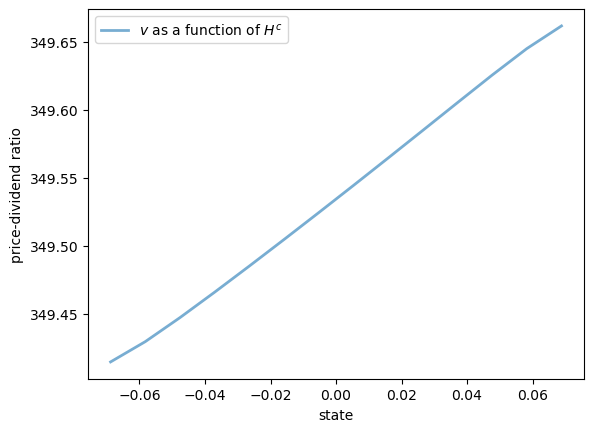

In [17]:
fig, ax = plt.subplots()
ax.plot(hc_grid, v[:, 0, 0], lw=2, alpha=0.6, label="$v$ as a function of $H^c$")
ax.set_ylabel("price-dividend ratio")
ax.set_xlabel("state")
ax.legend()
plt.show()

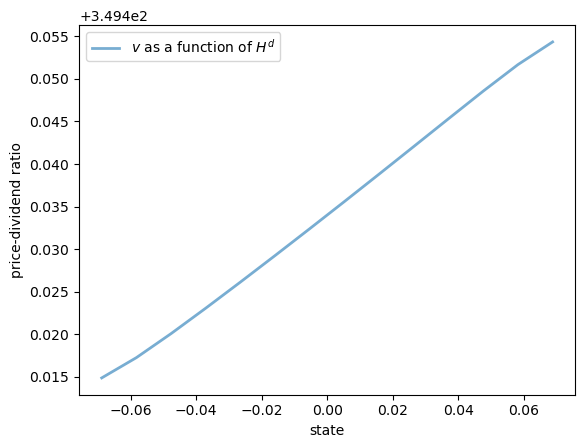

In [18]:
fig, ax = plt.subplots()
ax.plot(hd_grid, v[0, :, 0], lw=2, alpha=0.6, label="$v$ as a function of $H^d$")
ax.set_ylabel("price-dividend ratio")
ax.set_xlabel("state")
ax.legend()
plt.show()

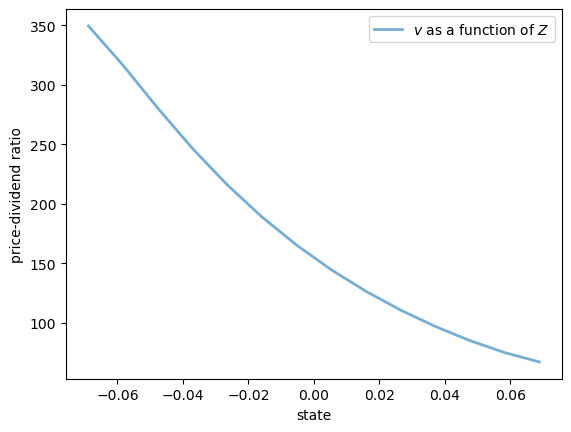

In [19]:
fig, ax = plt.subplots()
ax.plot(z_grid, v[0, 0, :], lw=2, alpha=0.6, label="$v$ as a function of $Z$")
ax.set_ylabel("price-dividend ratio")
ax.set_xlabel("state")
ax.legend()
plt.show()

## JAX Version



Now let's write a JAX version that is a simple transformation of the NumPy version.

(Below we will write a more efficient version using JAX's ability to work with linear operators.)

In [20]:
def create_sv_model_jax(sv_model):    # mean growth of dividends

    # Take the contents of a NumPy sv_model instance
    P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model

    # Shift the arrays to the device (GPU if available)
    hc_grid, hd_grid, z_grid = map(jax.device_put, (hc_grid, hd_grid, z_grid))
    P, Q, R = map(jax.device_put, (P, Q, R))

    # Create a new instance and return it
    return SVModel(P=P, hc_grid=hc_grid,
                   Q=Q, hd_grid=hd_grid,
                   R=R, z_grid=z_grid,
                   β=β, γ=γ, bar_σ=bar_σ, μ_c=μ_c, μ_d=μ_d)

Here's a function to compute $H$.

We include the extra argument `shapes` to help the compiler understand the size of the arrays.

This is important when we JIT-compile the function below.

In [21]:
def compute_H_jax(sv_model, shapes):
    # Set up
    P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model
    I, J, K = shapes
    N = I * J * K
    # Reshape and multiply pointwise using broadcasting
    hc = jnp.reshape(hc_grid, (I, 1, 1))
    hd = jnp.reshape(hd_grid, (1, J, 1))
    z = jnp.reshape(z_grid, (1, 1, K))
    P = jnp.reshape(P, (I, 1, 1, I, 1, 1))
    Q = jnp.reshape(Q, (1, J, 1, 1, J, 1))
    R = jnp.reshape(R, (1, 1, K, 1, 1, K))
    # Compute H and then reshape to create a matrix
    a = μ_d - γ * μ_c
    b = bar_σ**2 * (jnp.exp(2 * hd) + γ**2 * jnp.exp(2 * hc)) / 2
    κ = jnp.exp(a + (1 - γ) * z + b)
    H = β * κ * P * Q * R
    H = jnp.reshape(H, (N, N))
    return H

Here's the function that computes the solution.

In [22]:
def sv_pd_ratio_jax(sv_model, shapes):
    """
    Computes the price-dividend ratio of the asset for the stochastic volatility
    model.

    Parameters
    ----------
    sv_model: an instance of Model
        contains primitives

    Returns
    -------
    v : array_like
        price-dividend ratio

    """
    # Setp up
    P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model
    I, J, K = len(hc_grid), len(hd_grid), len(z_grid)
    shapes = I, J, K
    N = I * J * K

    H = compute_H_jax(sv_model, shapes)

    # Compute v, reshape and return
    ones_array = jnp.ones(N)
    Id = jnp.identity(N)
    v = jax.scipy.linalg.solve(Id - H, H @ ones_array)
    return jnp.reshape(v, (I, J, K))

Now let's target these functions for JIT-compilation, while using `static_argnums` to indicate that the function will need to be recompiled when `shapes` changes.

In [23]:
compute_H_jax = jax.jit(compute_H_jax, static_argnums=(1,))
sv_pd_ratio_jax = jax.jit(sv_pd_ratio_jax, static_argnums=(1,))

In [24]:
sv_model = create_sv_model()
sv_model_jax = create_sv_model_jax(sv_model)
P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model_jax
shapes = len(hc_grid), len(hd_grid), len(z_grid)

Let's see how long it takes to run with compile time included.

In [25]:
qe.tic()
v_jax = sv_pd_ratio_jax(sv_model_jax, shapes).block_until_ready()
jnp_time_0 = qe.toc()

TOC: Elapsed: 0:00:0.36


And now let's see without compile time.

In [26]:
qe.tic()
v_jax = sv_pd_ratio_jax(sv_model_jax, shapes).block_until_ready()
jnp_time_1 = qe.toc()

TOC: Elapsed: 0:00:0.01


Here's the ratio of times:

In [27]:
jnp_time_1 / np_time

0.013523181069663189

Let's check that the NumPy and JAX versions realize the same solution.

In [28]:
v = jax.device_put(v)

print(jnp.allclose(v, v_jax))

True


## Efficient JAX Version



One problem with the code above is that we instantiate a matrix of size $N = I \times J \times K$.

This quickly becomes impossible as $I, J, K$ increase.

Fortunately, JAX makes it possible to solve for the price-dividend ratio without instantiating this large matrix.

The first step is to think of $H$ not as a matrix, but rather as the linear operator that transforms $g$ into $Hg$ via

$$
    (Hg)[i, j, k] =
    \beta \sum_{i', j', k'}
        \kappa[i, j, k] g[i', j', k'] P[i, i']Q[j, j']R[k, k']
$$

In [29]:
def H_operator(g, sv_model, shapes):
    # Set up
    P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model
    I, J, K = shapes
    # Reshape and multiply pointwise using broadcasting
    hc = jnp.reshape(hc_grid, (I, 1, 1))
    hd = jnp.reshape(hd_grid, (1, J, 1))
    z = jnp.reshape(z_grid, (1, 1, K))
    P = jnp.reshape(P, (I, 1, 1, I, 1, 1))
    Q = jnp.reshape(Q, (1, J, 1, 1, J, 1))
    R = jnp.reshape(R, (1, 1, K, 1, 1, K))
    a = μ_d - γ * μ_c
    b = bar_σ**2 * (jnp.exp(2 * hd) + γ**2 * jnp.exp(2 * hc)) / 2
    κ = jnp.exp(a + (1 - γ) * z + b)
    H = β * κ * P * Q * R
    Hg = jnp.sum(H * g, axis=(3, 4, 5))
    return Hg

Now we write a version of the solution function that acts directly on this linear operator.

In [30]:
def sv_pd_ratio_jax_multi(sv_model, shapes):

    # Setp up
    P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model
    I, J, K = shapes

    # Compute v
    ones_array = np.ones((I, J, K))
    # Set up the operator g -> g
    H = lambda g: H_operator(g, sv_model, shapes)
    # Set up the operator g -> (I - H) g
    J = lambda g: g - H(g)
    # Solve v = (I - H)^{-1} H 1
    H1 = H_operator(ones_array, sv_model, shapes)
    v = jax.scipy.sparse.linalg.bicgstab(J, H1)[0]
    return v

Let's target these functions for JIT compilation.

In [31]:
H_operator = jax.jit(H_operator, static_argnums=(2,))
sv_pd_ratio_jax_multi = jax.jit(sv_pd_ratio_jax_multi, static_argnums=(1,))

Let's time the solution with compile time included.

In [32]:
qe.tic()
v_jax_multi = sv_pd_ratio_jax(sv_model, shapes).block_until_ready()
jnp_time_multi_0 = qe.toc()

TOC: Elapsed: 0:00:0.01


In [33]:
print(jnp.allclose(v, v_jax_multi))

True


Now let's run again without compile time.

In [34]:
qe.tic()
v_jax_multi = sv_pd_ratio_jax(sv_model, shapes).block_until_ready()
jnp_time_multi_1 = qe.toc()

TOC: Elapsed: 0:00:0.01


Here's the ratio of times (Efficient JAX / JAX):

In [35]:
jnp_time_multi_1 / jnp_time_1  

1.024968394437421

The speed is about the same but now we can work with much larger grids.

Here's a moderately large example, where the state space has 15,625 elements.

In [36]:
sv_model = create_sv_model(I=25, J=25, K=25)
sv_model_jax = create_sv_model_jax(sv_model)
P, hc_grid, Q, hd_grid, R, z_grid, β, γ, bar_σ, μ_c, μ_d = sv_model_jax
shapes = len(hc_grid), len(hd_grid), len(z_grid)

In [37]:
qe.tic()
v_jax_multi = sv_pd_ratio_jax(sv_model, shapes).block_until_ready()
jnp_time_multi_1 = qe.toc()

TOC: Elapsed: 0:00:0.94


In [38]:
qe.tic()
v_jax_multi = sv_pd_ratio_jax(sv_model, shapes).block_until_ready()
jnp_time_multi_1 = qe.toc()

TOC: Elapsed: 0:00:0.48
